In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, AveragePooling2D,MaxPooling2D
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score
from scipy import interp
import matplotlib.pyplot as plt
import time

In [2]:
#loading data
dataset = np.load('data.row/ASD.npz') #Dataset ready in numpy array (removing background, resizing, and transforming into grayscale)
X = dataset['X']
y = dataset['y']

print(X.shape)
print(y.shape)

(3103, 256, 256, 1)
(3103, 1)


In [3]:
#Hyperparameters
nfolds = 3
nEpochs = 10
nBatch= 16
#inputDim = X.shape[1] # Count of features

In [4]:
kfold = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=1).split(X, y) #Cross validation
tprs = []
aucs = []

recall =[]
precision = []

mean_fpr = np.linspace(0, 1, 100)

start = time.time()
hists_CNN = []
for train, test in kfold:
  model = Sequential()
  model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=X.shape[1:]))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.20))

  model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.20))

  model.add(Conv2D(32, (3, 3),padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.20))

  model.add(Conv2D(32, (3, 3),padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.20))
  
  model.add(Flatten())
  
  model.add(Dense(256, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  #model.summary()
  
  #Fiting the model 
  hist = model.fit(X[train], y[train], validation_split=0.2, epochs=nEpochs, batch_size=nBatch, verbose=0)
  
  pred = model.predict(X[test]).ravel()

  #Calculating Recall and precision
  recall.append( recall_score(y[test], pred.round()) )
  precision.append( precision_score(y[test], pred.round()) )

  #ROC AUC
  fpr, tpr, thresholds = roc_curve(y[test], pred)
  tprs.append(interp(mean_fpr, fpr, tpr))
  tprs[-1][0] = 0.0
  roc_auc = auc(fpr, tpr)
  print(roc_auc)
  aucs.append(roc_auc)
  hists_CNN.append(hist)

end = time.time()

print("Avg AUC:", np.mean(aucs))

print("Avg Recall:", np.mean(recall))
print("Avg Precision:", np.mean(precision))

print("Training Time:", end - start, "seconds.") #Using Tesla K80 GPU

C:\Users\fatemeh\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


0.9502138672783064
0.9677984993475425
0.9716336295283664
Avg AUC: 0.9632153320514051
Avg Recall: 0.9101731601731601
Avg Precision: 0.9262207529720676
Training Time: 2590.259500026703 seconds.


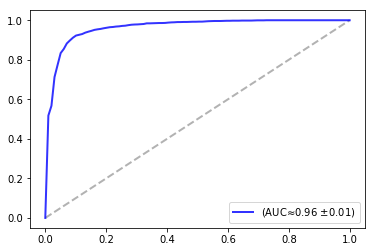

In [5]:
#ROC curve
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black',alpha=0.3)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'(AUC≈%0.2f $\pm$%0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)
plt.legend(loc="lower right")